In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Local Macbook Pro


In [3]:
stack_fixed = 'RV4_67hrs'
stack_moving = 'RV14_65hrs'
# stack_moving = 'RV13_64hrs'
# stack_moving = 'RV19_61hrs''

# stack_moving = 'atlasV5'

In [4]:
warp_setting = 24
# warp_setting = 16
# Adding surr is essential.

In [5]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [6]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True
    
print surround_weight, include_surround

upstream_warp_id                                                               None
transform_type                                                               affine
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                      2000
std_ty_um                                                                      2000
std_tz_um                                                                      2000
std_theta_xy_degree                                                              30
surround_weight                                                             inverse
regularization_weight                                                           NaN
comment                           global reg with surr no grid search; count

In [8]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20

lr1 = 10
lr2 = 0.1

In [54]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='annotationAsScore', 
                                                      include_surround=include_surround,
                                                     structures=['Sp5I_L', 'Sp5I_R',
                                                                 'LRt_L', 'LRt_R',
                                                                 '7N_L', '7N_R', 
                                                                 'Sp5C_L', 'Sp5C_R',
                                                                 '5N_L', '5N_R', 
                                                                 '7n_L', '7n_R', 
                                                                 'Sp5O_L', 'Sp5O_R'])
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume/score_volumes"


Execution failed: [Errno 12] Cannot allocate memory
Score volume for Sp5I_L does not exist: [Errno 12] Cannot allocate memory


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume/score_volumes"


Execution failed: [Errno 12] Cannot allocate memory
Score volume for Sp5O_L does not exist: [Errno 12] Cannot allocate memory
Volume shape: (259, 536, 529)


(259, 536, 529)


In [14]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround,
                                                     structures=['Sp5I_L', 'Sp5I_R',
                                                                 'LRt_L', 'LRt_R',
                                                                 '7N_L', '7N_R', 
                                                                 'Sp5C_L', 'Sp5C_R',
                                                                 '5N_L', '5N_R', 
                                                                 '7n_L', '7n_R', 
                                                                 'Sp5O_L', 'Sp5O_R'])
print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


(246, 609, 459)


Volume shape: (246, 609, 459)


In [24]:
structure_subset = all_known_structures_sided

In [25]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [26]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [28]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [29]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [30]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [32]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [58]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving['7N_L']])
# Sometimes initialize with SNR_L centers results in zero gradient. In those cases use another structure.

centroid_m: [ 170.03129184  189.75071091  124.78854903], centroid_f: [ 182.9970302   174.35975548   90.48145744]


In [40]:
aligner.set_label_weights(label_weights=label_weights_m)

In [41]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [44]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14])
load gradient 1: 2.465839 seconds
load gradient 2: 1.545738 seconds
load gradient 3: 1.476172 seconds
load gradient 4: 1.575104 seconds
load gradient 5: 1.554973 seconds
load gradient 6: 2.524242 seconds
load gradient 7: 2.300250 seconds
load gradient 8: 1.670529 seconds
load gradient 9: 1.679464 seconds
load gradient 10: 1.576702 seconds
load gradient 12: 1.547742 seconds
load gradient 14: 1.876611 seconds
overall: 21.794543 seconds


In [59]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
#                                      max_iter_num=100,
                                     max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=1, lr2=.1,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
Image gradient at all valid voxel is zero.


In [61]:
from skimage.filters import gaussian

In [ ]:
volume_moving_smoothed = {ind_m: gaussian(v, 3) for ind_m, v in volume_moving.iteritems()}

In [ ]:
volume_fixed_smoothed = {ind_f: gaussian(v, 11) for ind_f, v in volume_fixed.iteritems()}

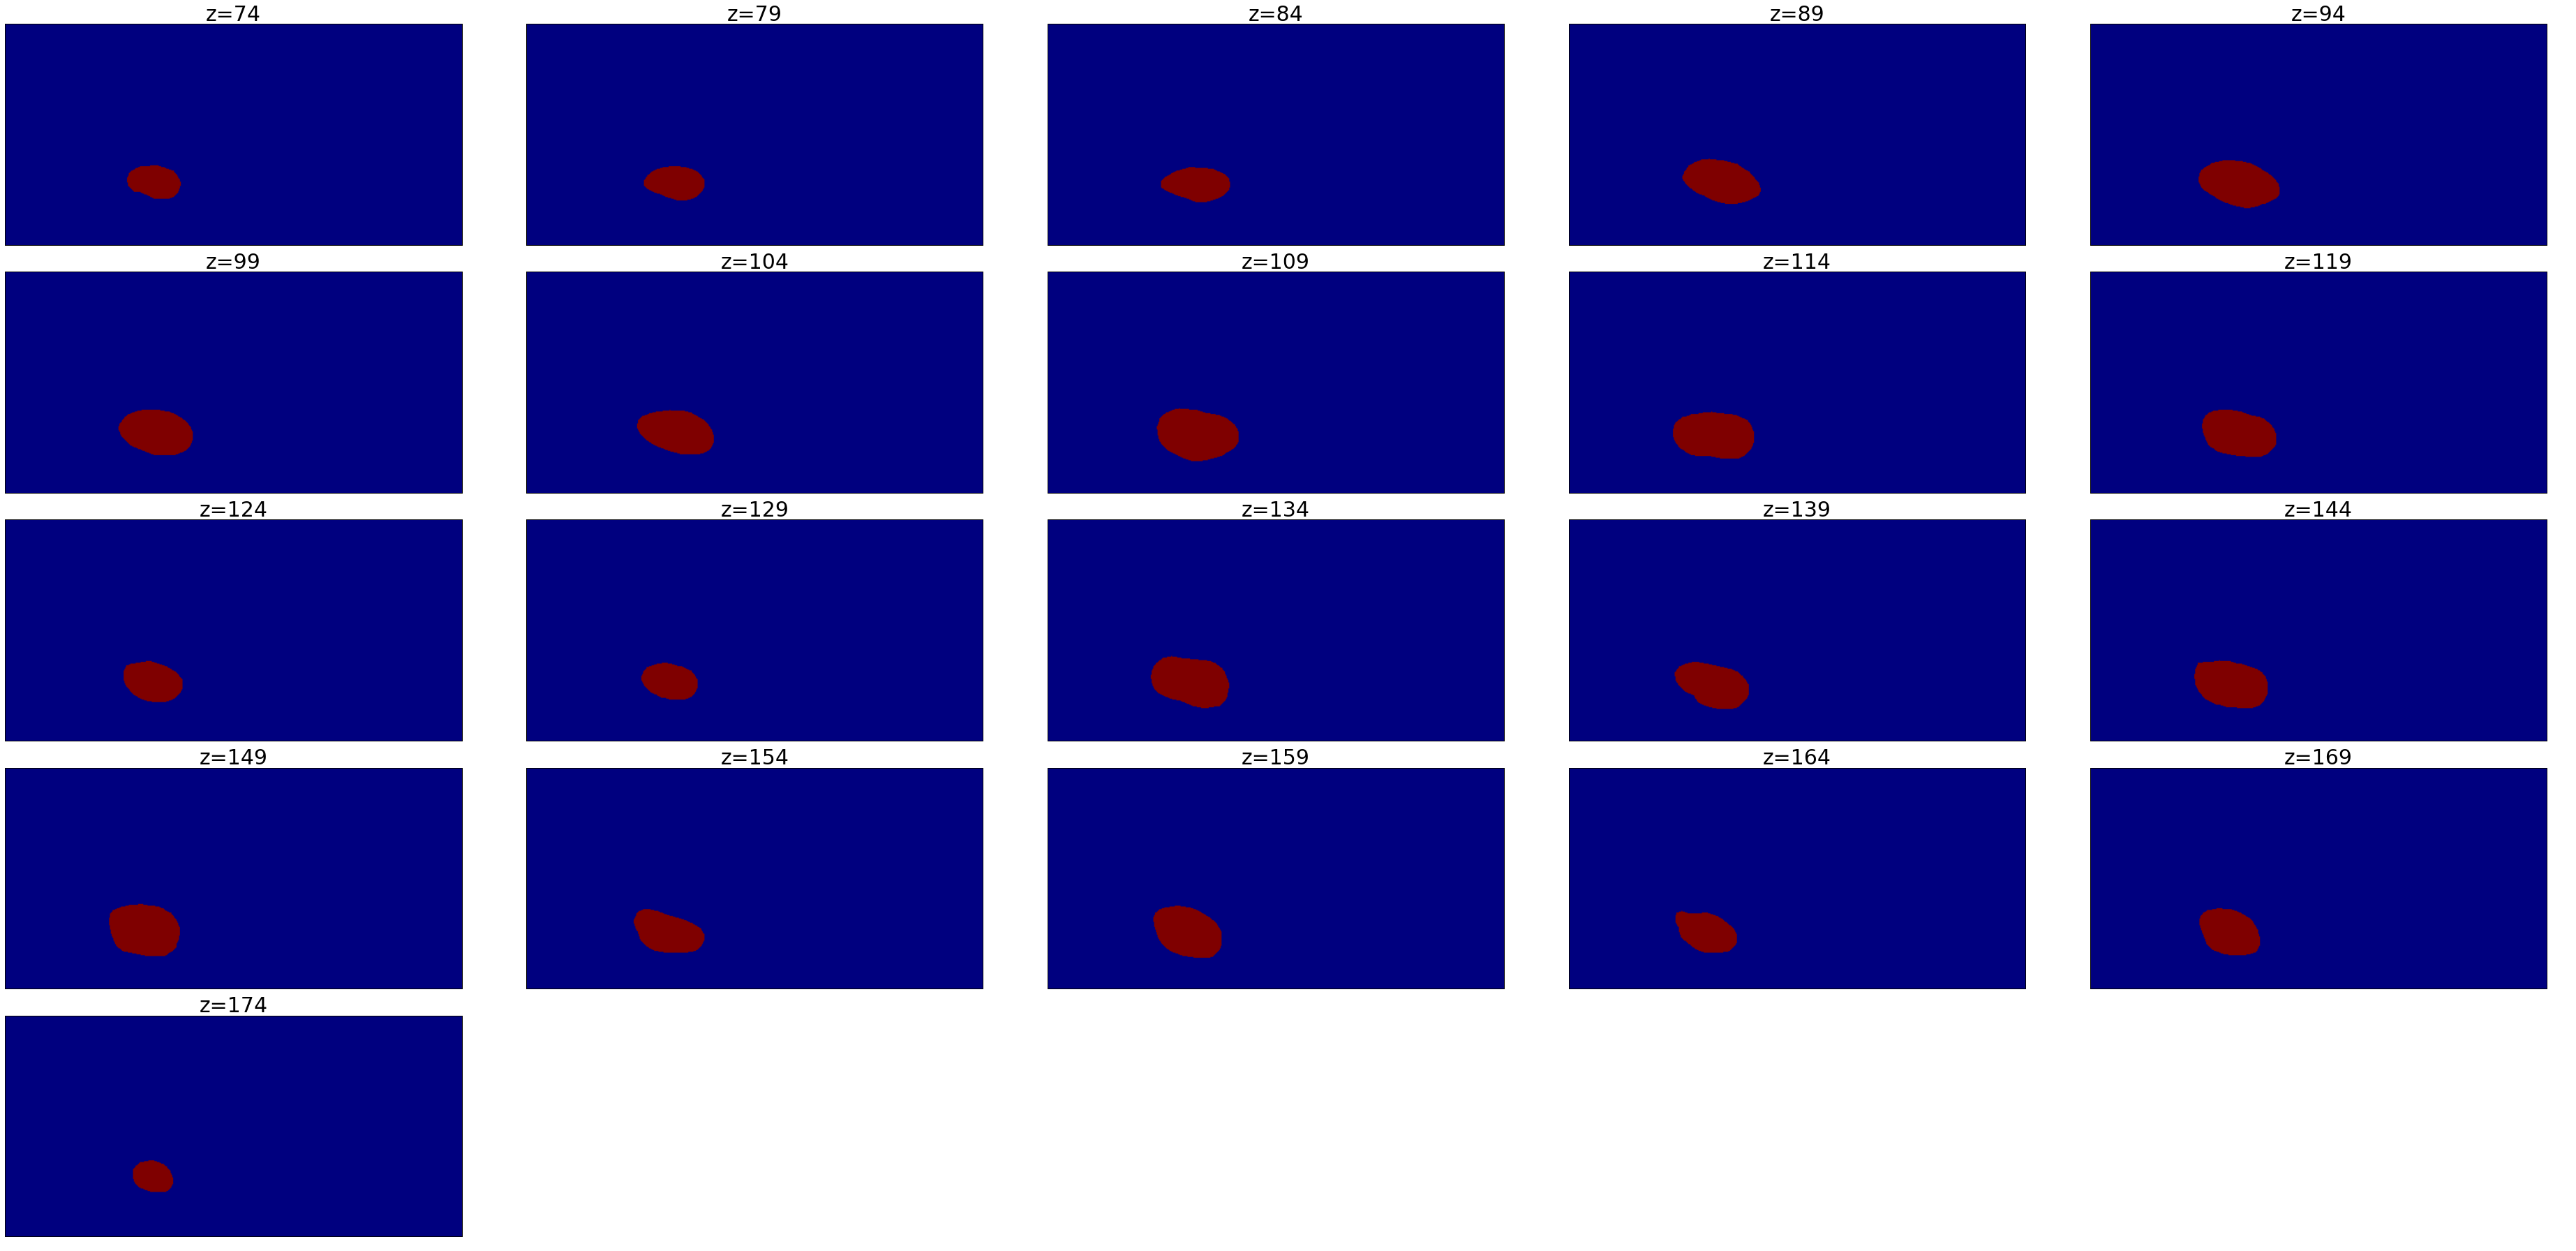

In [60]:
display_volume_sections(volume_moving[structure_to_label_moving['7N_L']])

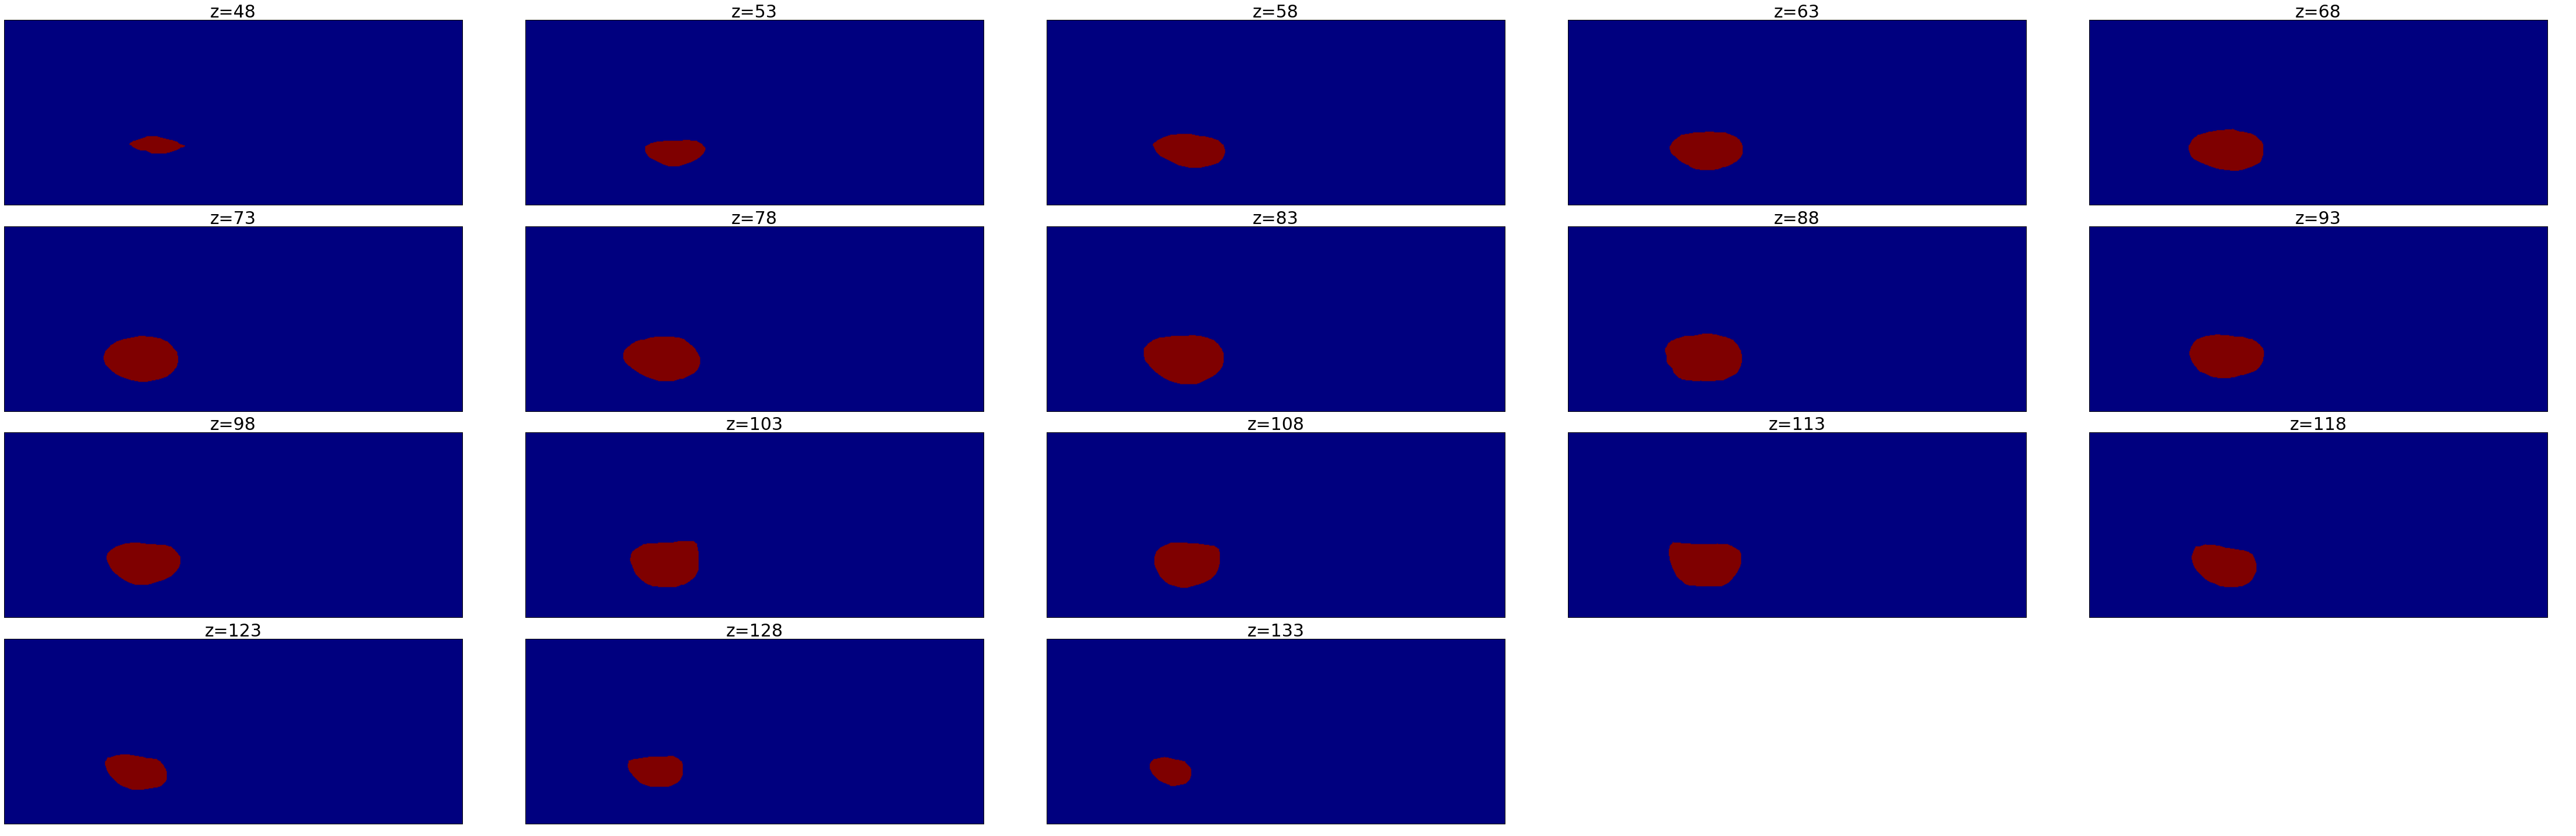

In [51]:
display_volume_sections(volume_fixed[structure_to_label_fixed['7N_L']])

In [11]:
import xml.etree.ElementTree as ET

def get_stacy_contours(stack):

#     xmlfile = '/shared/stacy_data/%s.xml' % stack
    xmlfile = '/home/yuncong/stacy_data/%s.xml' % stack
    download_from_s3(xmlfile)

    # create element tree object
    tree = ET.parse(xmlfile)

    # get root element
    root = tree.getroot()

    prefix = '{http://www.mbfbioscience.com/2007/neurolucida}'

    # neurolucida_name_map = \
    # {"Contour Name 1": 'RMC',
    # "Contour Name 2": '3N',
    # "Contour Name 3": 'fr',
    # 'Brain': 'outerContour',
    #  'SNR': 'SNR'}

    neurolucida_name_map = \
    {"IO": 'IO_L',
    "LRT": 'LRt_L',
    # "BRAINSTEM": 'brainstem',
    '5 MOTOR': '5N_L',
     '7n': '7n_L',
    'AMB MOTOR': 'Amb_L',
    'FACIAL MOTOR': '7N_L',
     'SpVC': 'Sp5C_L',
     'SpVO': 'Sp5O_L',
     'Sp5I': 'Sp5I_L',
     'Pr5': 'Pr5_L',
     'Sol': 'Sol_L',
     'Li': 'Li_L',
    #  'SpVIO': 'unknown',
    'R LrT': 'LRt_R',
    'R FN':  '7N_R',
    'R_7n': '7n_R',
    'R 5N':  '5N_R',
    'R SpVC': 'Sp5C_R',
    'R Sp5I': 'Sp5I_R',
    'R SpVO': 'Sp5O_R',
    'R Pr5':  'Pr5_R',
    'R IO':  'IO_R',
     'R-SpVI':  'Sp5I_R',
    'R-SpV':  'Sp5_R',
    'R-SpVO':  'Sp5O_R',
     'R-PrV':  'Pr5_R',
     'R-Amb':  'Amb_R',
    #  'R SpVIO':  'unknown',
     'SpVC_R':  'Sp5C_R',
     'R 5M':  '5N_R',
    #  'User Line 5':  'unknown',
    #  'NewContour': 'unknown',
    #   'User Line 2':  'unknown',
    }

    contours = defaultdict(list)

    for item in root.findall(prefix+'contour'):
        name = item.attrib['name']
        if name not in neurolucida_name_map:
    #         raise Exception('Name %s in stack %s not recognized' % (name, stack))
            sys.stderr.write('Name %s in stack %s not recognized. Ignored.\n' % (name, stack))
            continue
        name = neurolucida_name_map[name]
        curr_contour = []
    #     try:
    #         resolution = float(item.findall(prefix+'resolution')[0].text)
    #         print resolution
    #     except:
    #         pass
        for p in item.findall(prefix+'point'):
            curr_contour.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
        contours[name].append(np.array(curr_contour))

    contours.default_factory = None

    #################

    # structure_subset = ['3N_L', 'RMC_L', 'SNR_L']
    structure_subset = \
    [name for name in contours.keys() if parse_label(name)[0] in all_known_structures]
    print structure_subset

    ####################

    downscale = 32

    if stack == 'RV4_67hrs' or stack == 'RV19_61hrs' or stack == 'RV9_53hrs':
        contours_orientationCorrected = {name_u: [cnt*[1,-1,1]
                                         for cnt in cnts3d if len(cnt) > 2] 
                               for name_u, cnts3d in contours.iteritems()}
    else:
        contours_orientationCorrected = {name_u: [cnt*[-1,-1,1]
                                         for cnt in cnts3d] 
                               for name_u, cnts3d in contours.iteritems()}

    contours_atlasResol = {name: [cnt / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                                    for cnt in cnts3d] 
                           for name, cnts3d in contours_orientationCorrected.iteritems()
                                                if name in structure_subset}

    
    #####################
    
    markers = defaultdict(list)
#     markers = {}

    for item in root.findall(prefix+'marker'):
        curr_markers = []
        for p in item.findall(prefix+'point'):
            curr_markers.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
        name = '7N_R'
        markers[name].append(np.array(curr_markers))
        
    markers = {name: np.concatenate(mkr_lists) for name, mkr_lists in markers.iteritems()}

    # markers.default_factory = None
    
    #########################
    
    if stack == 'RV4_67hrs' or stack == 'RV19_61hrs' or stack == 'RV9_53hrs':

        markers_orientationCorrected = {name_u: mkrs3d*[1,-1,1]
                               for name_u, mkrs3d in markers.iteritems()}

    else:
        markers_orientationCorrected = {name_u: mkrs3d*[-1,-1,1]
                           for name_u, mkrs3d in markers.iteritems()}

    markers_atlasResol = {name: mkrs3d / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                           for name, mkrs3d in markers_orientationCorrected.iteritems()
                         if name in structure_subset}
    
    
    return contours_atlasResol, markers_atlasResol

In [4]:
stack_fixed = 'RV4_67hrs'
# stack_moving = 'RV14_65hrs'
# stack_moving = 'RV13_64hrs'
# stack_moving = 'RV19_61hrs'

stacks_to_colors = {'RV4_67hrs': (1,0,0), 'RV14_65hrs': (0,1,0), 'RV19_61hrs': (0,0,1), 'RV13_64hrs': (1,1,0)}

Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignore

['LRt_R', 'Sp5I_R', '7N_R', 'Sp5C_L', 'Sp5I_L', '7n_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5C_R', 'Sp5O_R', 'Sp5O_L', 'LRt_L']


Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. I

['Sp5O_R', 'Sp5I_R', 'Sp5C_L', '7N_R', '5N_R', '5N_L', '7N_L', 'Sp5C_R', '7n_L', 'Amb_R', '7n_R', 'Amb_L', 'LRt_R', 'LRt_L']
[[ 1.11534825 -0.07524286  0.02318577 -1.77539378]
 [ 0.06689717  0.80876742 -0.01631299  4.08417546]
 [ 0.02639557 -0.10721925  0.88553802 -0.46894708]
 [ 0.          0.          0.          1.        ]]
rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" "/shared/CSHL

File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp
Error loading volume for 6N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp
Error loading volume for 6N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp
Error loading volume for LC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp
Error loading volume for LC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp
Error loading volume for Pn_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp
Error loading volume for Pn_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp
Error loading volume for Tz_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp
Error loading volume for Tz_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp
Error loading volume for VLL_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp
Error loading volume for VLL_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp
Error loading volume for RMC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp
Error loading volume for RMC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp
Error loading volume for SNC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp
Error loading volume for SNC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp
Error loading volume for SNR_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp
Error loading volume for SNR_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp
Error loading volume for 3N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp
Error loading volume for 3N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp
Error loading volume for 4N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp
Error loading volume for 4N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp
Error loading volume for Sp5I_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp
Error loading volume for Sp5O_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp
Error loading volume for PBG_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp
Error loading volume for PBG_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp
Error loading volume for 10N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp
Error loading volume for 10N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp
Error loading volume for VCA_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp
Error loading volume for VCA_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp
Error loading volume for VCP_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp
Error loading volume for VCP_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp
Error loading volume for DC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp
Error loading volume for DC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp
Error loading volume for AP: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp
Error loading volume for 12N: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp
Error loading volume for RtTg: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp
Error loading volume for SC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp
Error loading volume for IC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R_parameters.txt" && mkdir -p "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R_parameters.txt" "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R_parameters

File does not exist: /shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R_parameters.txt
Error loading structure-specific transform for Amb_R: [Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R_parameters.txt'.


rm -rf "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" && mkdir -p "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters

File does not exist: /shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt
Error loading structure-specific transform for Amb_L: [Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt'.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignore

['LRt_R', 'Sp5I_R', '7N_R', 'Sp5C_L', 'Sp5I_L', '7n_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5C_R', 'Sp5O_R', 'Sp5O_L', 'LRt_L']


Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not r

['LRt_R', 'Sp5O_R', 'Sp5C_L', 'Sp5I_L', '7N_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5I_R', 'Sp5C_R', '7n_R', 'Amb_L', 'LRt_L']
[[  1.08231686e+00  -1.28037567e-01   2.56404784e-02   1.44663392e+00]
 [  3.54973800e-02   1.04735856e+00  -2.09458349e-02  -2.99914673e+00]
 [  1.56415793e-02   1.04571170e-01   9.60718763e-01  -1.58829785e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsS

File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp
Error loading volume for 6N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp
Error loading volume for 6N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp
Error loading volume for Amb_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp
Error loading volume for LC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp
Error loading volume for LC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp
Error loading volume for Pn_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp
Error loading volume for Pn_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp
Error loading volume for Tz_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp
Error loading volume for Tz_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp
Error loading volume for VLL_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp
Error loading volume for VLL_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp
Error loading volume for RMC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp
Error loading volume for RMC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp
Error loading volume for SNC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp
Error loading volume for SNC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp
Error loading volume for SNR_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp
Error loading volume for SNR_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp
Error loading volume for 3N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp
Error loading volume for 3N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp
Error loading volume for 4N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp
Error loading volume for 4N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp
Error loading volume for Sp5O_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp
Error loading volume for PBG_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp
Error loading volume for PBG_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp
Error loading volume for 10N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp
Error loading volume for 10N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp
Error loading volume for VCA_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp
Error loading volume for VCA_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp
Error loading volume for VCP_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp
Error loading volume for VCP_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp
Error loading volume for DC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp
Error loading volume for DC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp
Error loading volume for AP: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp
Error loading volume for 12N: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp
Error loading volume for RtTg: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp
Error loading volume for SC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp
Error loading volume for IC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" && mkdir -p "/shared/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" "/shared/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters

File does not exist: /shared/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt
Error loading structure-specific transform for Amb_L: [Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt'.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignore

['LRt_R', 'Sp5I_R', '7N_R', 'Sp5C_L', 'Sp5I_L', '7n_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5C_R', 'Sp5O_R', 'Sp5O_L', 'LRt_L']


Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not r

['LRt_R', '7N_R', 'Sp5C_L', '7n_R', '5N_R', '5N_L', '7N_L', '7n_L', 'Sp5I_R', 'Sp5C_R', 'Amb_L', 'LRt_L']
[[  1.13142565e+00  -1.10682488e-01   4.05661194e-03  -2.91735602e-01]
 [  1.79845625e-02   1.09989262e+00   7.62957960e-04  -1.00592691e+01]
 [  3.86288713e-02  -1.67812243e-01   1.03764161e+00   9.58196473e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV

File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp
Error loading volume for 6N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp
Error loading volume for 6N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp
Error loading volume for Amb_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp
Error loading volume for LC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp
Error loading volume for LC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp
Error loading volume for Pn_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp
Error loading volume for Pn_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp
Error loading volume for Tz_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp
Error loading volume for Tz_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp
Error loading volume for VLL_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp
Error loading volume for VLL_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp
Error loading volume for RMC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp
Error loading volume for RMC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp
Error loading volume for SNC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp
Error loading volume for SNC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp
Error loading volume for SNR_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp
Error loading volume for SNR_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp
Error loading volume for 3N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp
Error loading volume for 3N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp
Error loading volume for 4N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp
Error loading volume for 4N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp
Error loading volume for Sp5I_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp
Error loading volume for Sp5O_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp
Error loading volume for Sp5O_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp
Error loading volume for PBG_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp
Error loading volume for PBG_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp
Error loading volume for 10N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp
Error loading volume for 10N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp
Error loading volume for VCA_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp
Error loading volume for VCA_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp
Error loading volume for VCP_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp
Error loading volume for VCP_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp
Error loading volume for DC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp
Error loading volume for DC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp
Error loading volume for AP: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp
Error loading volume for 12N: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp
Error loading volume for RtTg: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp
Error loading volume for SC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp
Error loading volume for IC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" && mkdir -p "/shared/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" "/shared/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters

File does not exist: /shared/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt
Error loading structure-specific transform for Amb_L: [Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt'.


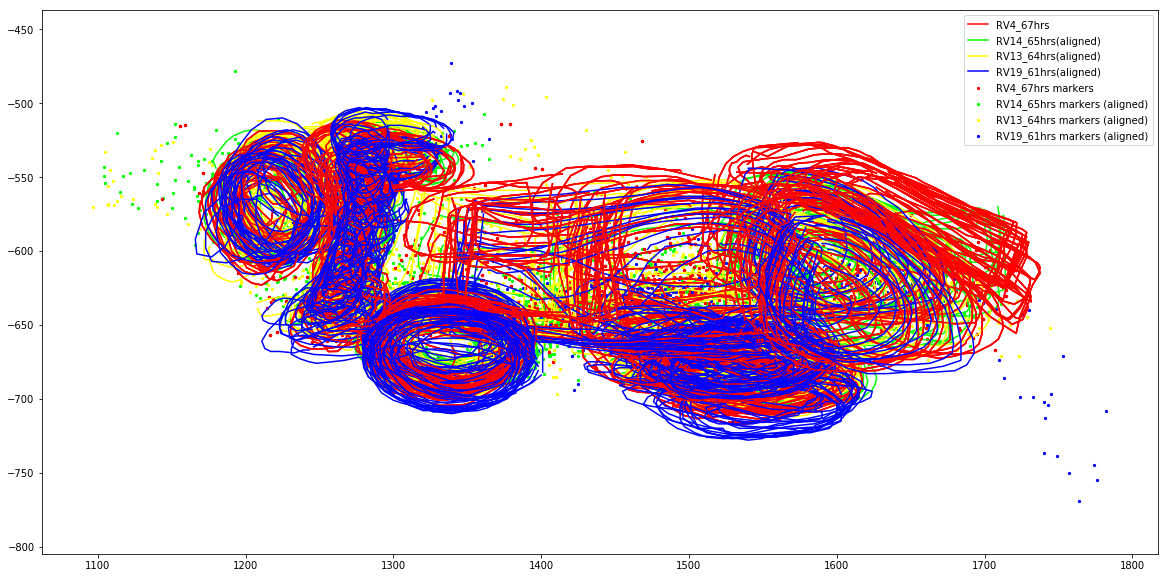

In [81]:
plt.figure(figsize=(20,10));

for stack_moving in ['RV14_65hrs', 'RV13_64hrs', 'RV19_61hrs']:
# for stack_moving in ['RV14_65hrs']:

    annvol_m_bbox_rel2world = DataManager.load_original_volume_bbox(stack=stack_moving, structure='7N_L', downscale=32, volume_type='annotationAsScore')
    annvol_f_bbox_rel2world = DataManager.load_original_volume_bbox(stack=stack_fixed, structure='7N_L', downscale=32, volume_type='annotationAsScore')

    contours_f_rel2world, markers_f_rel2world = get_stacy_contours(stack_fixed)
    contours_m_rel2world, markers_m_rel2world = get_stacy_contours(stack_moving)

    #############################

    global_params, cm_rel2ann, cf_rel2ann, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
    DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
                                                        warp_setting=20, 
                                                             vol_type_m='annotationAsScore', 
                                                             vol_type_f='annotationAsScore', downscale=32)
    T_annvolm2annvolf = consolidate(global_params, cm_rel2ann, cf_rel2ann)
    print T_annvolm2annvolf

    ############################

    # L_annvolm2annvolf = {}
    # for structure in set(contours_m_rel2world.keys()) & set(contours_f_rel2world.keys()) :
    #     local_params, cm_rel2ann, cf_rel2ann, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
    #     DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
    #                                                         warp_setting=17, 
    #                                                              vol_type_m='annotationAsScore', 
    #                                                              vol_type_f='annotationAsScore', downscale=32,
    #                                          structure_m=structure,
    #                                          structure_f=structure)

    #     L_annvolm2annvolf[structure] = consolidate(local_params, cm_rel2ann, cf_rel2ann)

    #############################

    contours_m2fc_rel2world = {name_s: 
        [transform_points_affine([[1,0,0,0],[0,1,0,0],[0,0,1,0]], cnt_m_rel2world - annvol_m_bbox_rel2world[[0,2,4]]) + annvol_f_bbox_rel2world[[0,2,4]] 
        for cnt_m_rel2world in cnts_m_rel2world]
     for name_s, cnts_m_rel2world in contours_m_rel2world.iteritems()}

    ################################

    contours_m2fg_rel2world = {name_s: 
        [transform_points_affine(T_annvolm2annvolf[:3], cnt_m_rel2world - annvol_m_bbox_rel2world[[0,2,4]]) + annvol_f_bbox_rel2world[[0,2,4]] 
        for cnt_m_rel2world in cnts_m_rel2world]
     for name_s, cnts_m_rel2world in contours_m_rel2world.iteritems()}

    #######################

#     contours_m2fl_rel2world = {name_s: 
#             [transform_points_affine(L_annvolm2annvolf[name_s][:3], cnt_m2fg_rel2world - annvol_f_bbox_rel2world[[0,2,4]]) + annvol_f_bbox_rel2world[[0,2,4]] 
#             for cnt_m2fg_rel2world in cnts_m2fg_rel2world]
#          for name_s, cnts_m2fg_rel2world in contours_m2fg_rel2world.iteritems() 
#                                if name_s in L_annvolm2annvolf}

    #########################

    rigid_param_list, anchor_points, sigmas, weights = \
    get_weighted_average_rigid_parameters(stack_m=stack_moving, stack_f=stack_fixed, 
                                          structures=all_known_structures_sided,
                                         alpha=100.)

    contours_m2fwa_rel2world = {name_s: 
                                [transform_points_polyrigid(cnt_m2fg_rel2world - annvol_f_bbox_rel2world[[0,2,4]], 
                                    rigid_param_list.values(), 
                                    anchor_points.values(), 
                                    sigmas.values(), 
                                    weights.values()) + annvol_f_bbox_rel2world[[0,2,4]] 
        for cnt_m2fg_rel2world in cnts_m2fg_rel2world]
     for name_s, cnts_m2fg_rel2world in contours_m2fg_rel2world.iteritems()}


    ######################

    markers_m2fg_rel2world = {name_s: 
        transform_points_affine(T_annvolm2annvolf[:3], marker_m_rel2world - annvol_m_bbox_rel2world[[0,2,4]]) + annvol_f_bbox_rel2world[[0,2,4]] 
     for name_s, marker_m_rel2world in markers_m_rel2world.iteritems()}

    ######################

    markers_m2fwa_rel2world = {name_s: 
        transform_points_polyrigid(marker_m2fg_rel2world - annvol_f_bbox_rel2world[[0,2,4]], 
                                    rigid_param_list.values(), 
                                    anchor_points.values(), 
                                    sigmas.values(), 
                                    weights.values()) + annvol_f_bbox_rel2world[[0,2,4]] 
     for name_s, marker_m2fg_rel2world in markers_m2fg_rel2world.iteritems()}

    ######################

    for structure in contours_f_rel2world.keys():
    # for structure in ['7N_R']:

        if structure in contours_f_rel2world:
            for cnt_f in contours_f_rel2world[structure]:
                plt.plot(cnt_f[:,0], -cnt_f[:,1], c=stacks_to_colors[stack_fixed], label=stack_fixed);

        if structure in contours_m2fwa_rel2world:
            for cnt_m2f in contours_m2fwa_rel2world[structure]:
                plt.plot(cnt_m2f[:,0], -cnt_m2f[:,1], c=stacks_to_colors[stack_moving], 
#                          label=stack_moving+'(weighted average of structure-wise transforms)');
                         label=stack_moving+'(aligned)');

    #     if structure in contours_m2fc_rel2world:
    #         for cnt_m2f in contours_m2fc_rel2world[structure]:
    #             plt.plot(cnt_m2f[:,0], cnt_m2f[:,1], c='c', label=stack_moving+'(bounding box origin aligned)');

    #     if structure in contours_m2fg_rel2world:
    #         for cnt_m2f in contours_m2fg_rel2world[structure]:
    #             plt.plot(cnt_m2f[:,0], -cnt_m2f[:,1], c='b', label=stack_moving+'(global aligned)');

    #     if structure in contours_m2fl_rel2world:
    #         for cnt_m2f in contours_m2fl_rel2world[structure]:
    #             plt.plot(cnt_m2f[:,0], cnt_m2f[:,1], c='g', label=stack_moving+'(local)');

    plt.scatter(markers_f_rel2world['7N_R'][:,0], -markers_f_rel2world['7N_R'][:,1], c=stacks_to_colors[stack_fixed], 
                label=stack_fixed+' markers', s=5);
    plt.scatter(markers_m2fwa_rel2world['7N_R'][:,0], -markers_m2fwa_rel2world['7N_R'][:,1], c=stacks_to_colors[stack_moving], 
#                 label=stack_moving+' markers (weighted average of structure-wise transforms)', 
                label=stack_moving+' markers (aligned)', 
                s=5);
    # plt.scatter(markers_m2fg_rel2world['7N_R'][:,0], markers_m2fg_rel2world['7N_R'][:,1], c='b', 
    #             label=stack_moving+' markers (global aligned)', s=2);
    # plt.scatter(markers_m2fl_rel2world['7N_R'][:,0], markers_m2fl_rel2world['7N_R'][:,1], c='g', 
    #             label=stack_moving+' markers (local)', s=2);

# Merge labels
# https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels);

plt.axis('equal');

# Visualize weighted average transform

In [45]:
from utilities2015 import *

In [75]:
grid_xyzs_m2fwa_rel2annvolf_allz = {}
for z in range(0, annvol_f_bbox_rel2world[5]-annvol_f_bbox_rel2world[4], 50):
    grid_xyzs_m2fg_rel2annvolf = return_gridline_points_v2(annvol_f_bbox_rel2world[1]-annvol_f_bbox_rel2world[0],
                                                           annvol_f_bbox_rel2world[3]-annvol_f_bbox_rel2world[2],
                                                           20,z)

    grid_xyzs_m2fwa_rel2annvolf = transform_points_polyrigid(grid_xyzs_m2fg_rel2annvolf, 
                                        rigid_param_list.values(), 
                                        anchor_points.values(), 
                                        sigmas.values(), 
                                        weights.values()) 

    # plt.figure(figsize=(10, 10));
#     plt.scatter(grid_xyzs_m2fwa_rel2annvolf[:,0], grid_xyzs_m2fwa_rel2annvolf[:,1], s=1)
#     plt.title('Deformation field @ z=%d' % z)
#     plt.show()
    
    grid_xyzs_m2fwa_rel2annvolf_allz[z] = grid_xyzs_m2fwa_rel2annvolf

In [76]:
grid_xyzs_m2fwa_rel2annvolf = np.concatenate(grid_xyzs_m2fwa_rel2annvolf_allz.values())

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10));
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grid_xyzs_m2fwa_rel2annvolf[:,0], grid_xyzs_m2fwa_rel2annvolf[:,1], grid_xyzs_m2fwa_rel2annvolf[:,2], 
           color='k', marker='.', s=.1, alpha=.5)
ax.view_init(30, 45)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax = plt.gca()
ax.grid(False)
plt.show()

In [212]:
fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                               vol_type_f='annotationAsScore',
                                               vol_type_m='annotationAsScore',
                                                  warp_setting=17,
                                               structure_m='5N_R',
                                               structure_f='5N_R',
                                               what='scoreHistory')
download_from_s3(fp, redownload=True)
scores = bp.unpack_ndarray_file(fp)

rm -rf "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R_scoreHistory.bp" && mkdir -p "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R_scoreHistory.bp" "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R_scoreHistory.bp"


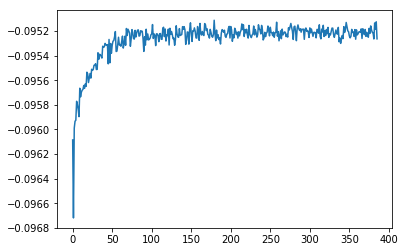

In [213]:
plt.plot(scores);